In [1]:
%config InlineBackend.figure_formats = ['retina']
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import optimizers

# Load data

In [2]:
names = ['Ant', 'Grapes']

In [3]:
X_ant = np.load('./data/G_21_ant.npy')
X_grapes = np.load('./data/G_21_grapes.npy')

In [4]:
X_test = np.load('./data/test_images.npy')
y_test = np.load('./data/test_labels.npy').astype(int)

# Creates labels for ant and grapes

ant := label $0$ and grapes := label $1$

In [5]:
y_ant = np.zeros((X_ant.shape[0],))
y_grapes = np.ones((X_grapes.shape[0],))

# Merge the data into one matrix

In [6]:
X_train = np.concatenate((X_ant, X_grapes), axis=0)

In [7]:
y_train = np.concatenate((y_ant, y_grapes), axis=0).astype(int)

In [8]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# PCA for dimensionality reduction

To use PCA, we need to standardise the data sets

In [10]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

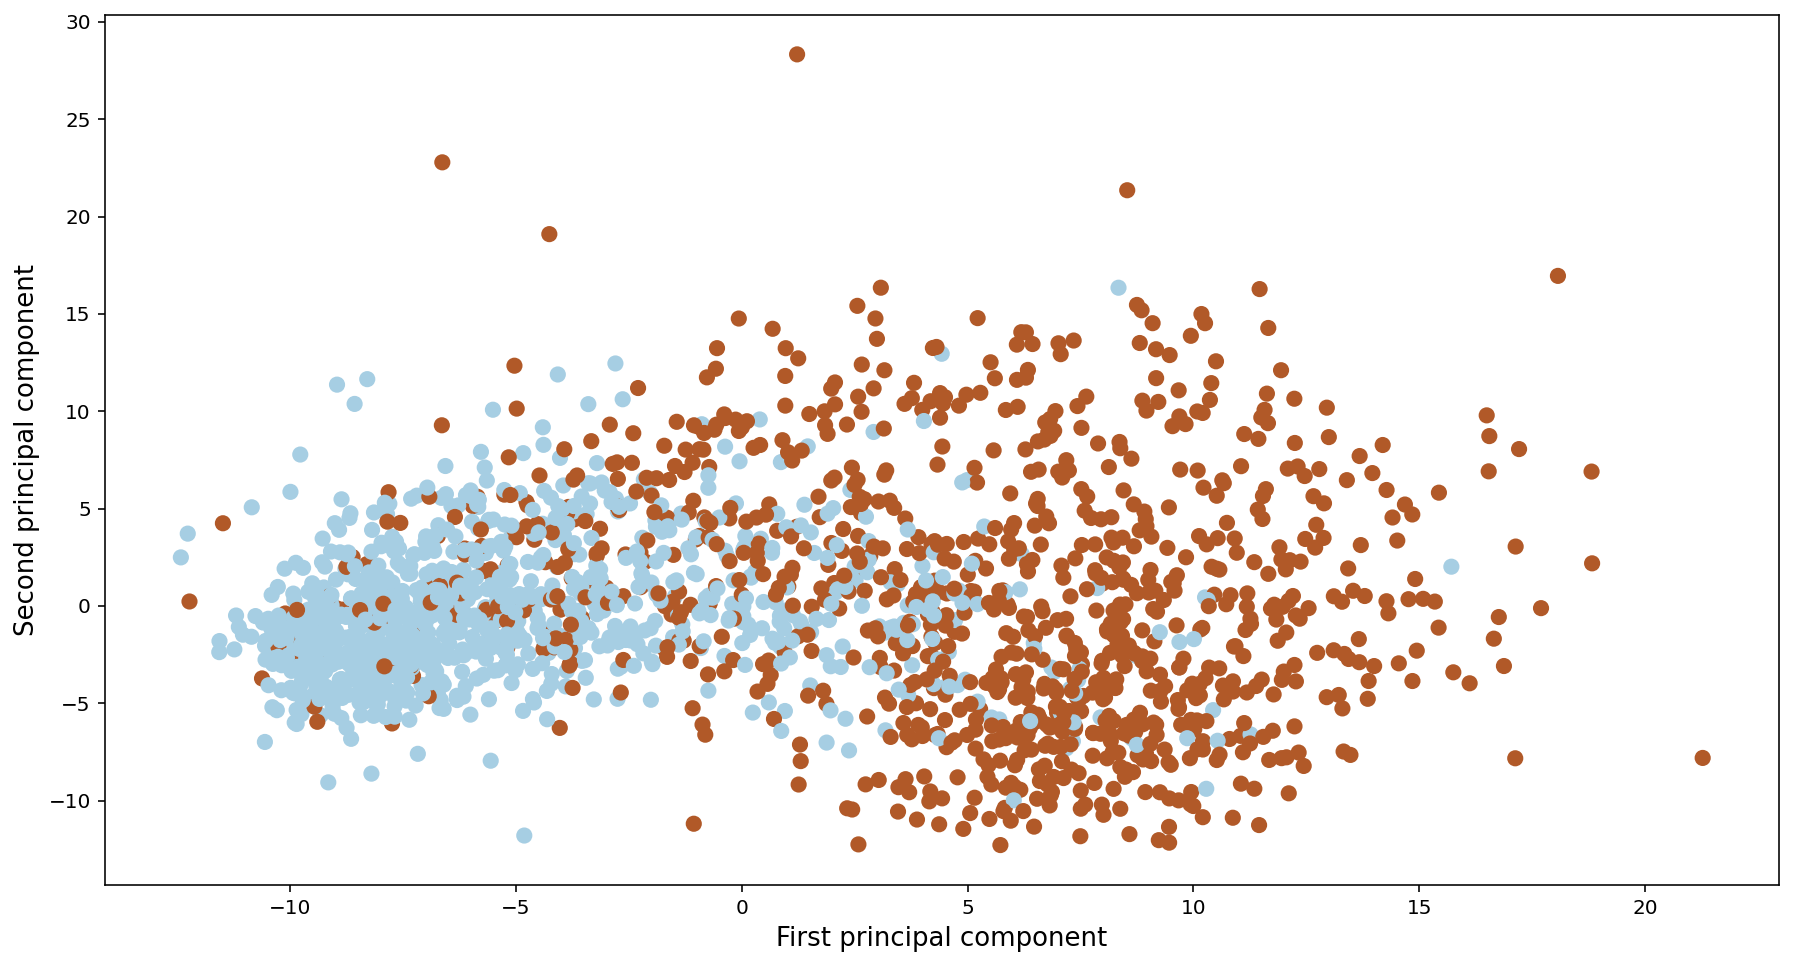

In [11]:
plt.figure(figsize=(15,8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, s=50, cmap=plt.cm.Paired)
plt.xlabel('First principal component', size=13)
plt.ylabel('Second principal component', size=13)
plt.show()

Thanks to the reduction of the dimension, we can plot the data in 2D. From the plot, we can see that the data is not linearly separable. We will therefore only use non-linear classifiers.

First, we will try to use SVM with a Gaussian kernel. The two other algorithms we will test to see if we get better results are decision trees and neural network.

# Use SVM to separate data with a Gaussian kernel

In [12]:
%%time
clf_rbf = SVC(kernel='rbf', C=2.5)
clf_rbf.fit(X_train, y_train)

CPU times: user 2.45 s, sys: 57.6 ms, total: 2.5 s
Wall time: 3.06 s


SVC(C=2.5)

In [13]:
clf_rbf.score(X_train, y_train), clf_rbf.score(X_test, y_test)

(0.9925, 0.863)

## Use cross-validation to find the best parameters

In [14]:
%%time
clf_rbf_cv = GridSearchCV(SVC(kernel='rbf'), param_grid={'C':range(1,11)})
clf_rbf_cv.fit(X_train, y_train)
print(clf_rbf_cv.best_params_)

{'C': 2}
CPU times: user 1min 17s, sys: 278 ms, total: 1min 17s
Wall time: 1min 17s


In [15]:
clf_rbf_cv.cv_results_['mean_test_score']

array([0.8705, 0.875 , 0.872 , 0.871 , 0.872 , 0.8715, 0.8715, 0.872 ,
       0.871 , 0.8715])

In [16]:
clf_rbf_cv.score(X_test, y_test)

0.863

## Plot the decision functions on the PC dimension reduction

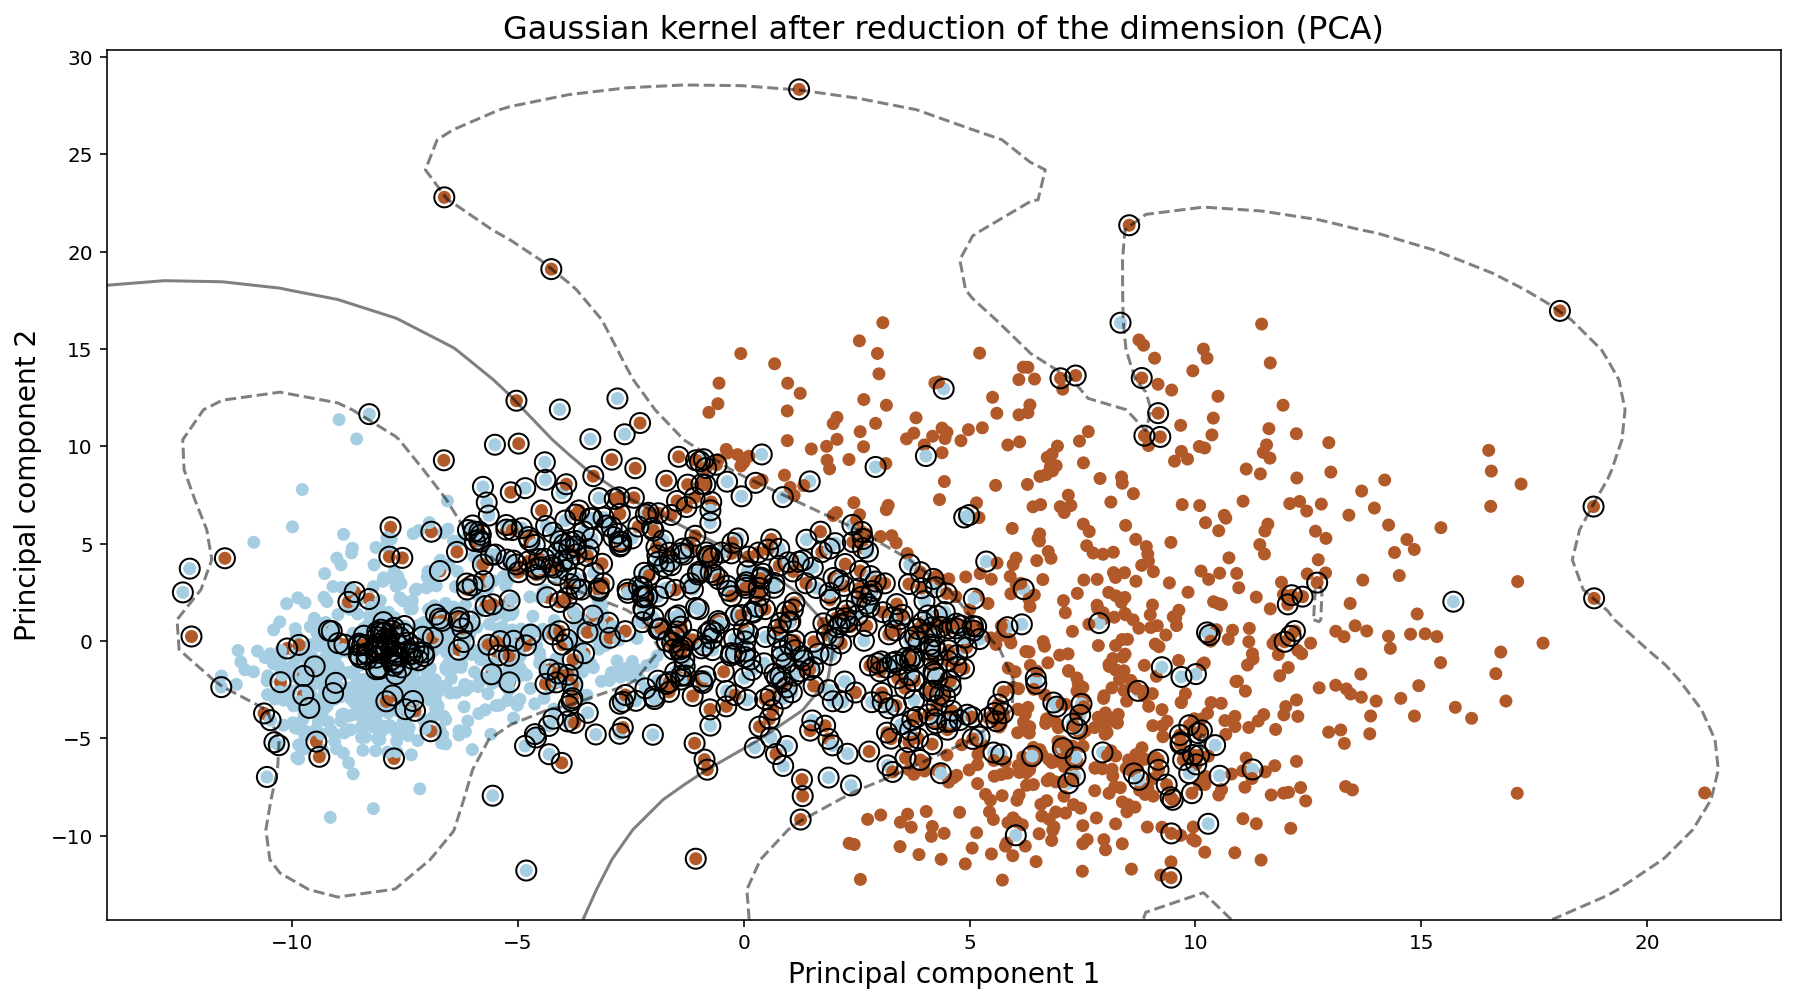

In [17]:
plt.figure(figsize=(15,8))
# plot the results in 2D to better understand the distribution of the data, plot with two different colors to see the classes
clf_rbf_2d = SVC(kernel='rbf', C=2.5)
clf_rbf_2d.fit(X_2d, y_train)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf_rbf_2d.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf_rbf_2d.support_vectors_[:, 0], clf_rbf_2d.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
plt.title('Gaussian kernel after reduction of the dimension (PCA)', size=16)
plt.xlabel('Principal component 1', size=14)
plt.ylabel('Principal component 2', size=14)
plt.show()

# KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [19]:
neigh.score(X_test, y_test)

0.85

In [20]:
## Cross validation on KNN 
knn = KNeighborsClassifier()
nb_neighbors = {'n_neighbors' : np.arange(1,30)}
neigh_cv = GridSearchCV(knn, param_grid = nb_neighbors)
neigh_cv.fit(X_train, y_train)
neigh_cv.score(X_test, y_test)

0.85

In [21]:
print('The best score of the model with CV is : {} for the {} neighbors'.format(neigh_cv.best_score_, neigh_cv.best_params_))

The best score of the model with CV is : 0.8485000000000001 for the {'n_neighbors': 3} neighbors


La Cross validation donne un score sensiblement meilleur que celui obtenu avec le noyau rbf

# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
dec_clf = DecisionTreeClassifier()
dec_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
dec_clf.score(X_test, y_test)

0.72

In [24]:
%%time 

d_tree = DecisionTreeClassifier()
params = {'criterion' : ['gini', 'entropy'], 'splitter' : ['best', 'random'], 'min_samples_leaf' : np.arange(1,40)}
dec_tree_cv = GridSearchCV(d_tree,params)
dec_tree_cv.fit(X_train,y_train)

CPU times: user 2min 11s, sys: 1.4 s, total: 2min 12s
Wall time: 2min 18s


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39]),
                         'splitter': ['best', 'random']})

In [25]:
dec_tree_cv.score(X_test,y_test)

0.791

> La modification du parametre 'min_samples_leaf' à l'air pertinente pour augmenter le score, il est peut être encore possible de l'augmenter. Néanmoins ce score est toujours en dessous de celui obtenu pour KNN.

In [26]:
print('The best score for the decision tree with cross validation is {}, it is obtained for the parameters {}'.format(dec_tree_cv.best_score_, dec_tree_cv.best_params_))

The best score for the decision tree with cross validation is 0.7965, it is obtained for the parameters {'criterion': 'entropy', 'min_samples_leaf': 26, 'splitter': 'random'}


# Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion='entropy', min_samples_leaf=10, max_samples=0.5, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_samples=0.5,
                       min_samples_leaf=10, random_state=0)

In [28]:
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.8995, 0.844)

Dans l'ensemble tous les algorithmes sont moins bon que SVM avec gaussian kernel, y'a juste KNN qui a quand même un plutôt bon score, avec de la cross-validation on peut peut-être faire un truc bien sinon les autres pas sûr qu'ils soient super utiles.

# Neural network

In [29]:
y_train_NN = to_categorical(y_train)
y_test_NN = to_categorical(y_test)

X_train = (X_train-np.mean(X_train, axis=1, keepdims=True))/np.std(X_train, axis=1, keepdims=True)

In [30]:
model = Sequential()
input_shape = 784
layer_1_shape = 300
output_shape = 2
model.add(Dense(layer_1_shape, activation='relu', input_dim=input_shape))
model.add(Dense(output_shape, activation='sigmoid'))

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
%%time
epochs=10
history = model.fit(X_train, y_train_NN, epochs=epochs, batch_size=10, validation_data=(X_test, y_test_NN))

Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6149 - accuracy: 0.8181 - val_loss: 0.5790 - val_accuracy: 0.7510
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1621 - accuracy: 0.9399 - val_loss: 0.6868 - val_accuracy: 0.7340
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0623 - accuracy: 0.9859 - val_loss: 0.6799 - val_accuracy: 0.7390
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0435 - accuracy: 0.9890 - val_loss: 0.6859 - val_accuracy: 0.7370
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.7164 - val_accuracy: 0.7510
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.7064 - val_accuracy: 0.7740
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.7367 - val_accuracy: 0.7690
Epoch 

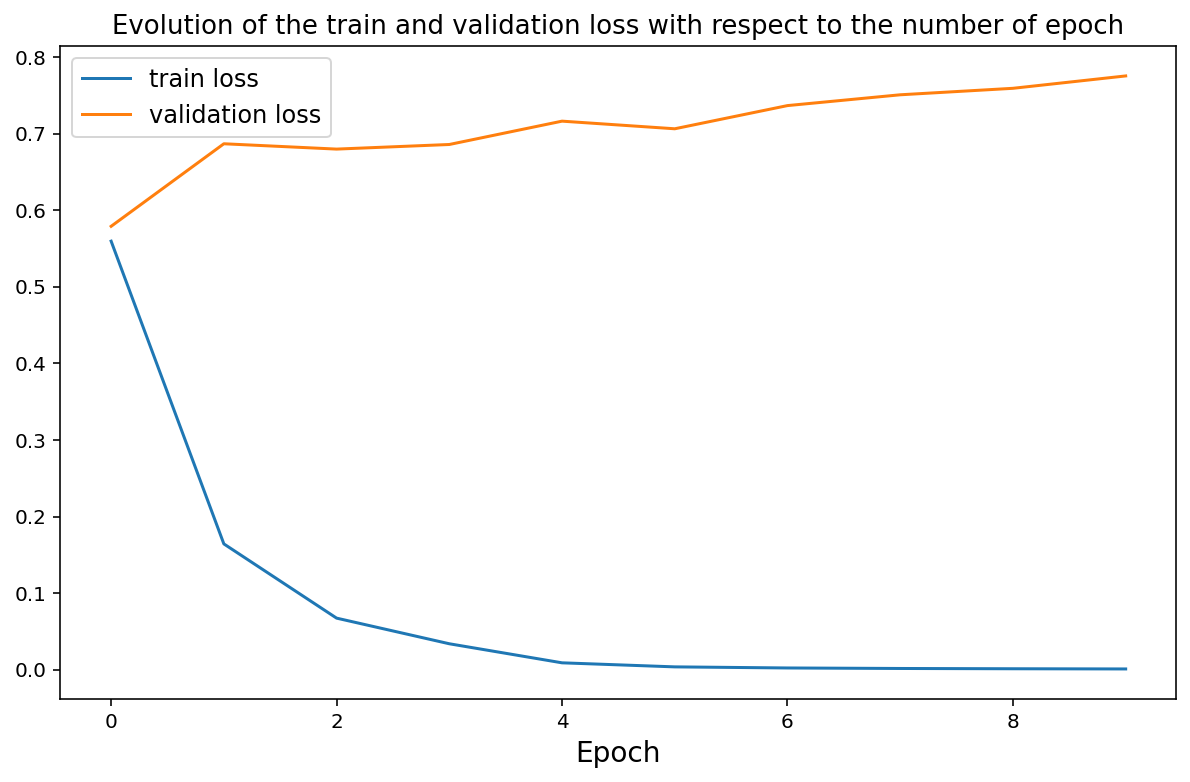

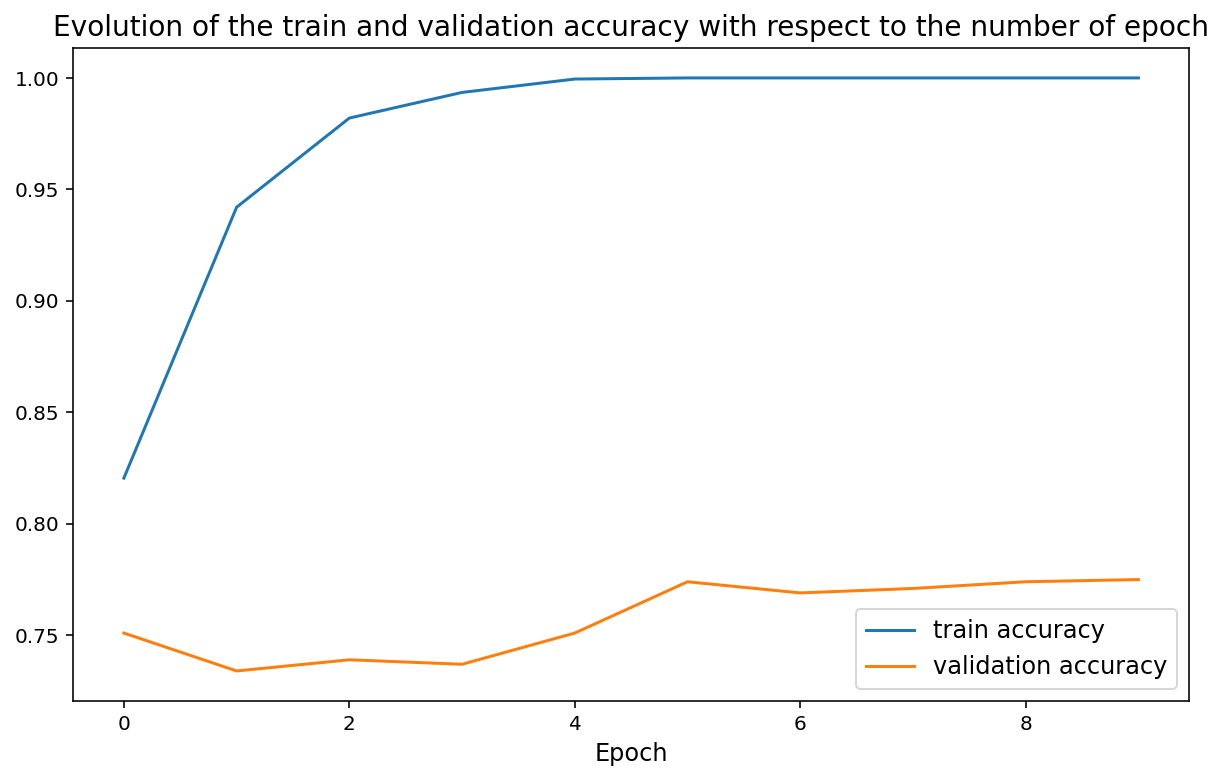

In [33]:
plt.figure(figsize=(10,6))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch', size=14)
plt.title('Evolution of the train and validation loss with respect to the number of epoch', size=13)

plt.legend(fontsize=12)
plt.show()

plt.figure(figsize=(10,6))

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch', size=12)
plt.title('Evolution of the train and validation accuracy with respect to the number of epoch', size=14)

plt.legend(fontsize=12)
plt.show()

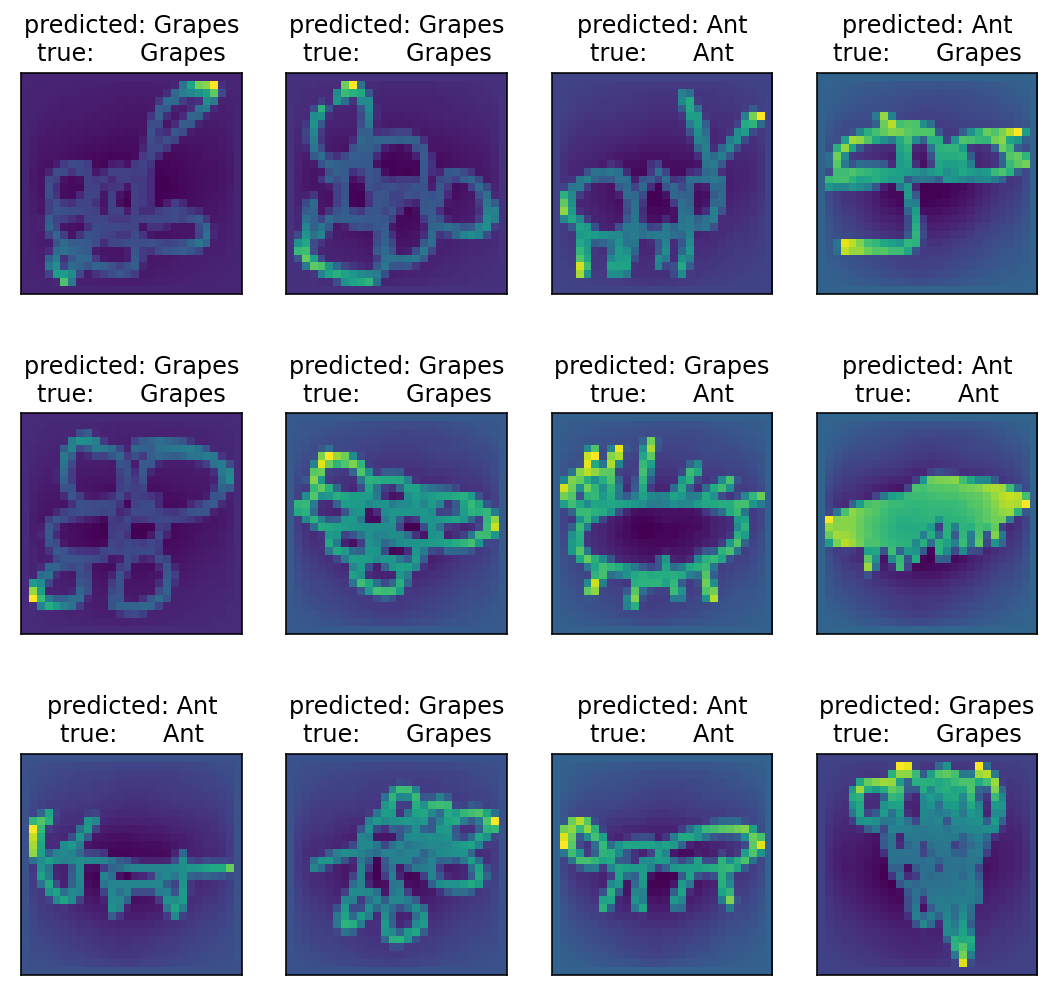

In [34]:
def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape(28,28,))
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


y_pred = clf_rbf.predict(X_test)
prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles)
pl.show()